# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# %load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)


# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Шпитальник".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)


Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = - \frac{1}{N}\left[ \sum_{i}\frac{e^{-y^{(i)}\sum_{j} (w_jx_j^{(i)})}y^{(i)}x_k^{(i)}}{1+e^{-y^{(i)}\sum_{j} x_j^{(i)}w_j}}\right] + \frac{2w_k}{C} = 
- \frac{1}{N}\left[ \sum_{i}\frac{y^{(i)}x_k^{(i)}}{1+e^{y^{(i)}\sum_{j} x_j^{(i)}w_j}}\right] + \frac{2w_k}{C} =  - \frac{1}{N}\left[ \sum_{i} y^{(i)}x_k^{(i)}\sigma(-y^{(i)}g(x^{(i)}))\right] + \frac{2w_k}{C} $$




## Имплементация (5 баллов)

In [3]:
# %%pycodestyle

from __future__ import division
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit
import math


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_num=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_num = batch_num

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        n = y.size
        i = np.arange(n)
        add = np.ones([X.shape[0], 1])
        x = np.append(add, X, axis=1)
        y_s = np.array(y, dtype=np.float64)
        self.classes = np.unique(y_s)
        for j in range(len(y_s)):
            if (y_s[j] == self.classes[0]):
                y_s[j] = 1
            else:
                y_s[j] = -1
        self.w = np.zeros(x.shape[1])
        self.ep_loss = np.array([self.loss(x, y_s)])
        for ep in range(self.max_epoch):
            np.random.shuffle(i)
            x_shuf = x[i, ]
            y_shuf = y_s[i, ]
            x_b = np.split(x_shuf, self.batch_num)
            y_b = np.split(y_shuf, self.batch_num)
            for j in range(self.batch_num - 1):
                step = self.alpha/(ep+1)
                batch_size = len(y_b[j])
                g = np.sum(self.w*x_b[j], axis=1)
                tmp = (y_b[j]*expit(-y_b[j]*g)).reshape(batch_size, 1)
                not_reg = -np.sum(x_b[j] * tmp, axis=0)/batch_size
                grad = not_reg + 2 * (self.w/self.C)
                self.w -= grad*step
            self.ep_loss = np.append(self.ep_loss, self.loss(x, y_s))
        return self

    def loss(self, x, y):
        g = np.sum(x*self.w, axis=1)
        loss = -np.sum(np.log(expit(y*g)), axis=0)/y.size + \
            sum(self.w**2)/self.C
        return loss

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self

    def predict(self, X):
        '''
         Возвращение метки класса
        '''
        res = self.predict_proba(X)
        y_hat = np.zeros(res.shape[1])
        p = res[0]
        for i in range(y_hat.shape[0]):
            if (p[i] > 0.5):
                y_hat[i] = 1
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        add = np.ones([X.shape[0], 1])
        x = np.append(add, X, axis=1)
        n = expit(np.sum(self.w*x, axis=1))
        p = 1 - n
        y_hat_proba = np.array([p, n])
        y_hat_proba = y_hat_proba
        return y_hat_proba


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

w0 = 2.4918847590364352
w1 = -0.6680077958900347
w2 = 0.5577704998353447


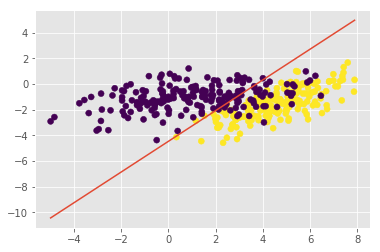

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

classifier = MySGDClassifier(max_epoch=20, C=1e5, alpha=1)
classifier.fit(X, y)
weights = classifier.w
for (i, w) in enumerate(weights):
    print 'w' + str(i) + ' = ' + str(w)

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
plt.plot(x, -(weights[0]+weights[1]*x)/weights[2])


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [5]:
from sklearn.datasets import make_classification

In [6]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Text(0,0.5,u'loss')

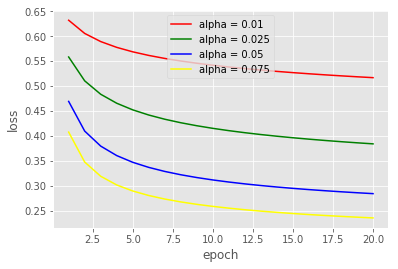

In [7]:
alpha = np.array([0.01, 0.025, 0.05, 0.075])
color = ["red", "green", "blue", "yellow"]
for i in range(len(alpha)):
    classifier = MySGDClassifier(max_epoch=20, C=1e5, alpha=alpha[i])
    classifier.fit(X, y)
    y_axis = classifier.ep_loss
    x_axis = np.arange(1, 21)
    plt.plot(
        x_axis, y_axis[1::], color=color[i],
        label=('alpha = ' + str(alpha[i])),
    )
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in double_scalars
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in square


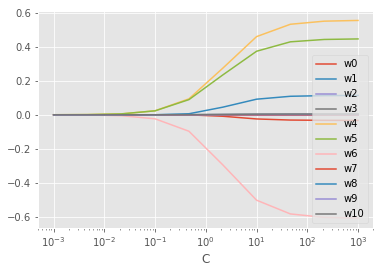

In [8]:
C = np.logspace(3, -3, 10)
w = np.zeros((10, X.shape[1]+1))
for (i, c) in enumerate(C):
    classifier = MySGDClassifier(max_epoch=100, C=c, alpha=0.05)
    classifier.fit(X, y)
    w[i] = classifier.w
for j in range(w.shape[1]):
    plt.semilogx(C, w[:, j], label=('w' + str(j)))
plt.xlabel("C")
plt.legend()


# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [9]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [10]:
df_data.shape

(2000000, 45)

In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [12]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [14]:
## Youd Code Here 
from sklearn.preprocessing import OneHotEncoder
player_card_num = len(pd.unique(df_data['player_hero_card_id']))
opponent_card_num = len(pd.unique(df_data['opponent_hero_card_id']))
df_data = pd.get_dummies(
    df_data, columns=['player_hero_card_id', 'opponent_hero_card_id']
)
print "различных карт героя у игрока " + str(player_card_num)
print "различных карт героя у противника " + str(opponent_card_num)


различных карт героя у игрока 9
различных карт героя у противника 9


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [15]:
# Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
y_train = df_data['decision'].values
X_train = df_data.drop(['decision'], axis=1).values
pipeline = Pipeline([
    ('scaller', StandardScaler()),
    ('model', MySGDClassifier(max_epoch=5, C=10000, alpha=0.05, batch_num=200))
])
pipeline.fit(X_train, y_train)


/home/alex/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaller', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=10000, alpha=0.05, batch_num=200, max_epoch=5))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [16]:
df_test_list = []
for chunk in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_test_list.append(pd.read_csv(filepath, sep=','))
df_test_data = pd.concat(df_test_list)


In [17]:
from sklearn.metrics import roc_auc_score
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')
df_test_data = pd.get_dummies(
    df_test_data, columns=['player_hero_card_id', 'opponent_hero_card_id']
)
df_test_labels = pd.read_csv(
    "./deprecated_testLabels.txt", sep='\n', names=['label']
)
y_test = df_test_labels['label'].values
X_test = df_test_data.drop(['decision'], axis=1).values
predicted = pipeline.predict_proba(X_test)
labels = predicted[0]
print roc_auc_score(y_test, labels)


0.7946114417601582
